<a href="https://colab.research.google.com/github/EytanTsytkin/DataScienceShorts/blob/main/Elections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [199]:
!pip3 install --upgrade pandas
!pip3 install --upgrade xlrd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [200]:
import io
import re
import csv
import sklearn
import scipy.stats
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import laplace
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import MinMaxScaler, normalize

sns.set_style('dark')

# **Overview**

In [201]:
# from google.colab import files
# uploaded = files.upload()

In [202]:
# Read the elections dataset:
df = pd.read_csv("elections_2021.csv",  encoding = 'iso-8859-8')
df.shape

(1215, 46)

In [203]:
party_names = [col for col in df.columns if col not in ['index', 'Name', 'Symbol', 'BZB', 'Voters', 'Disqualified', 'Eligible'] and len(col) > 3]
len(party_names)

15

In [204]:
# Read the cities dataset:
df_c = pd.read_excel('cities_israel.xls')
loc = df_c['coordinates']
c_symb = df_c['symbol']
symb_vec = df['Symbol']
df_c.shape

(1478, 23)

In [205]:
loc.shape
loc.isna().sum()

27

In [206]:
# Make a coordinates matrix:
c_mtx = np.zeros([loc.shape[0],2])
c_mtx[:, 0] = loc.apply(lambda x: str(x)[:5] if x > 10**4 else None)
c_mtx[:, 1] = loc.apply(lambda x: str(x)[5:] if x > 10**4 else None)
c_mtx.shape

(1478, 2)

In [207]:
# Fit the index of locations to the index of the data
n = len(symb_vec)
convert_idx = np.zeros(n,dtype = 'int')

for i in range(n):
    c_idx = np.where(c_symb==symb_vec[i])[0]
    if len(c_idx)>0:
        convert_idx[i]=c_idx

In [208]:
def plot_votes_by_location():
  fig_1, axs = plt.subplots(3,4,figsize = (13,10),constrained_layout=True)
  plt.suptitle('Israel - Voting by City',fontsize=14)
  for i,ax in enumerate(axs.flatten()):
      data = np.log(1+np.array(df[party_names[i]]))    
      ax.scatter(c_mtx[convert_idx,0],c_mtx[convert_idx,1],c = data,s=2,cmap='viridis',alpha=0.9)
      ax.tick_params(axis='both', which='both',          
                    bottom=False,labelbottom=False,
                    left=False,labelleft=False) 
      ax.set_xlim([10**4,3*10**4])
      ax.set_ylim([3*10**4,8.5*10**4])
      ax.set_title(party_names[i].capitalize())

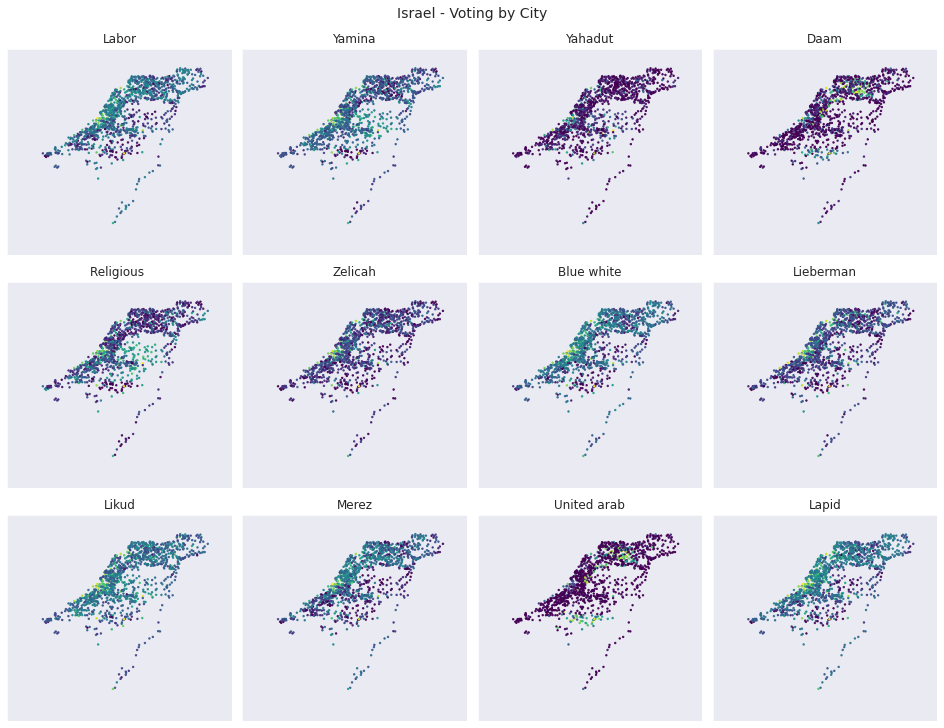

In [209]:
plot_votes_by_location()

# **Preprocessing**

In [210]:
obj_df = df_c.copy()
obj_df.columns

Index(['שם יישוב', 'שם יישוב.1', 'symbol', 'תעתיק', 'מחוז', 'נפה', 'אזור טבעי',
       'מעמד מונציפאלי', 'שיוך מטרופוליני', 'דת יישוב',
       'סך הכל אוכלוסייה 2014', 'יהודים ואחרים', 'יהודים', 'ערבים',
       'שנת ייסוד', 'צורת יישוב שוטפת', 'השתייכות ארגונית', 'coordinates',
       'גובה ', 'ועדת תכנון', 'תחנת משטרה', 'שנה', 'שדה לקישור'],
      dtype='object')

In [211]:
name_map ={
  "מחוז":"district",
  "דת יישוב":"religion",
  "שנת ייסוד":"Year of establishment",
  "יהודים ואחרים":"Jews and others",
  "יהודים":"Jews",
  "ערבים":"Arabs",
  "גובה ":"height",
  "סך הכל אוכלוסייה 2014":"population",
  "מעמד מונציפאלי":"muni_type"
}
obj_df.rename(columns=name_map,inplace=True)
obj_df.columns

Index(['שם יישוב', 'שם יישוב.1', 'symbol', 'תעתיק', 'district', 'נפה',
       'אזור טבעי', 'muni_type', 'שיוך מטרופוליני', 'religion', 'population',
       'Jews and others', 'Jews', 'Arabs', 'Year of establishment',
       'צורת יישוב שוטפת', 'השתייכות ארגונית', 'coordinates', 'height',
       'ועדת תכנון', 'תחנת משטרה', 'שנה', 'שדה לקישור'],
      dtype='object')

In [212]:
# We chose only the major influential parties and only the variables that we think are significant from the second file.
#  In addition, those with the right to vote, the number of voters and the invalid votes remained.

In [213]:
data = df.merge(obj_df ,how="left",left_on='Symbol', right_on='symbol')

In [214]:
data.head(2)

,index,Name,Symbol,BZB,Voters,Disqualified,Eligible,Labor,Yamina,Yahadut,...,Arabs,Year of establishment,צורת יישוב שוטפת,השתייכות ארגונית,coordinates,height,ועדת תכנון,תחנת משטרה,שנה,שדה לקישור
0,6,אבירים,1220,221,151,1,150,47,0,0,...,NaN,1980,370.0,19.0,2.271577e+09,561.0,255.0,1320.0,2014.0,http://gis.cbs.gov.il/Yeshuvim_allyears/start....
1,5,אדירים,113,234,180,0,180,1,7,4,...,NaN,1956,310.0,1.0,2.257972e+09,71.0,204.0,1420.0,2014.0,http://gis.cbs.gov.il/Yeshuvim_allyears/start....


In [215]:
reg = re.compile(r'[a-zA-Z]')
data.drop([col for col in data.columns if not reg.match(col)],axis=1,inplace=True)

In [216]:
# Filling nans:
data['Arabs'].fillna(0, inplace=True)
data['Jews and others'].fillna(0, inplace=True)
data['Jews'].fillna(0, inplace=True)
data['others'] = data['Jews and others'] - data['Jews']
data.drop(["Jews and others"],axis=1,inplace=True)
data['turnouts'] = data['Voters']/data['BZB']

In [217]:
# Let's look at district:
data['district'].isnull().sum()

4

In [218]:
data['district'].value_counts()

2.0    415
6.0    270
4.0    237
7.0    122
3.0     91
1.0     62
5.0     14
Name: district, dtype: int64

In [219]:
# Fill districs' nans with the most common value - 2
data["district"].fillna(2,inplace=True)

In [220]:
data['district'] = data['district'].astype(int)
dist_data = pd.get_dummies(data["district"],prefix='district')
data = data.join(dist_data)
data.head(2)

,index,Name,Symbol,BZB,Voters,Disqualified,Eligible,Labor,Yamina,Yahadut,...,height,others,turnouts,district_1,district_2,district_3,district_4,district_5,district_6,district_7
0,6,אבירים,1220,221,151,1,150,47,0,0,...,561.0,0.0,0.683258,0,1,0,0,0,0,0
1,5,אדירים,113,234,180,0,180,1,7,4,...,71.0,0.0,0.769231,0,1,0,0,0,0,0


In [221]:
# Let's look at religion:
data['religion'].isnull().sum()

14

In [222]:
data["religion"].value_counts()

1.0    1047
2.0     125
3.0      20
4.0       9
Name: religion, dtype: int64

In [223]:
# Again - fill with most common value
data["religion"].fillna(1,inplace=True)

In [224]:
data['religion'] = data['religion'].astype(int)
reli_data = pd.get_dummies(data["religion"],prefix='religion')
data = data.join(reli_data)
data.head(2)

,index,Name,Symbol,BZB,Voters,Disqualified,Eligible,Labor,Yamina,Yahadut,...,district_2,district_3,district_4,district_5,district_6,district_7,religion_1,religion_2,religion_3,religion_4
0,6,אבירים,1220,221,151,1,150,47,0,0,...,1,0,0,0,0,0,1,0,0,0
1,5,אדירים,113,234,180,0,180,1,7,4,...,1,0,0,0,0,0,1,0,0,0


In [225]:
data.drop(["religion","district"],axis=1,inplace=True)
data.isnull().sum().sum()

265

In [226]:
# Let's look at height:
data['height'].isnull().sum()

31

In [227]:
# Fill na's with median:
data['height'].fillna(data['height'].median(), inplace=True)

In [228]:
# Year of establishment:
data['Year of establishment'].isnull().sum()

159

In [229]:
data['Year of establishment'].value_counts()

1949    123
1950    101
1948     47
1980     35
1953     34
       ... 
1918      1
2006      1
1999      1
1870      1
2004      1
Name: Year of establishment, Length: 109, dtype: int64

In [230]:
non_numerics = data['Year of establishment'].astype(str).apply(lambda x: x if not x.isnumeric() else None)
non_numerics.value_counts()

nan     159
ותיק      4
Name: Year of establishment, dtype: int64

In [231]:
# Let's replace "ותיק" with the minimal year of establishment:
numerics = data['Year of establishment'].astype(str).apply(lambda x: x if x.isnumeric() else None)
min_year = min(numerics[~numerics.isna()].astype(int))
min_year
type(min_year)

int

In [232]:
data['Year of establishment'].replace('ותיק',min_year,inplace=True)

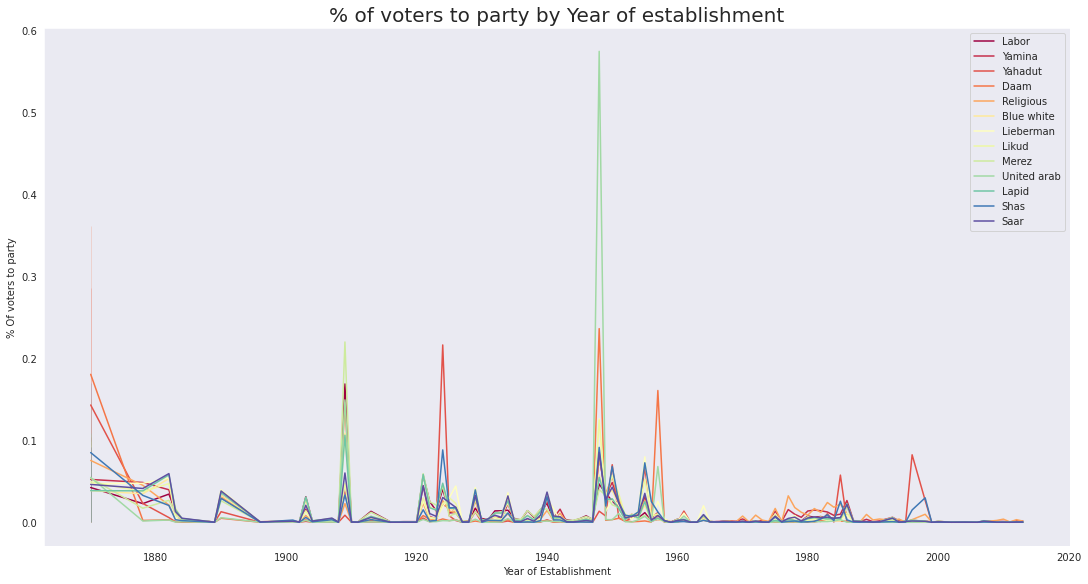

In [233]:
# Let's see the distirbution of each party's voters year of establisment:
f = plt.figure(figsize = (15,8),constrained_layout=True)
cmap = plt.cm.get_cmap('Spectral',15)
for idx,p in enumerate(party_names):
  if p in ['zelicah','pirates']:
    continue
  g = data[p].groupby(data['Year of establishment']).agg(sum)
  sns.lineplot(x=g.index,y=g.values/g.sum(),color=cmap(idx),label=p.capitalize())
plt.xlabel("Year of Establishment")
plt.ylabel("% Of voters to party")
plt.title("% of voters to party by Year of establishment",fontsize=20)
plt.legend()


In [234]:
# Let's fill the year of establishment nans with the year that is closest
# to the voting composition of the settlement.
years_df = df[party_names].groupby(data['Year of establishment']).agg(sum)
years_df['Total_Votes'] = years_df[party_names].sum(axis=1)
for col in party_names:
  years_df[col] = years_df[col]/years_df['Total_Votes']
years_df.drop('Total_Votes',axis=1,inplace=True)
years_df.head()

,Labor,Yamina,Yahadut,Daam,religious,zelicah,blue white,lieberman,likud,merez,united arab,Lapid,pirates,shas,saar
Year of establishment,,,,,,,,,,,,,,,
1870,0.046993,0.058544,0.161426,0.030367,0.071712,0.005975,0.048617,0.047241,0.224115,0.043265,0.002227,0.101607,0.000231,0.117144,0.040535
1870,0.121739,0.069565,0.000000,0.000000,0.026087,0.008696,0.069565,0.069565,0.226087,0.078261,0.000000,0.278261,0.000000,0.008696,0.043478
1878,0.041373,0.089069,0.042326,0.000614,0.070194,0.009166,0.071635,0.077864,0.276429,0.022529,0.000102,0.165201,0.000307,0.073950,0.059240
1882,0.053966,0.062875,0.009100,0.000694,0.028211,0.010720,0.094810,0.076576,0.303200,0.030512,0.000157,0.215326,0.000231,0.039850,0.073772
1883,0.093250,0.064605,0.004213,0.001024,0.023876,0.011557,0.130526,0.030810,0.235626,0.056822,0.000059,0.252041,0.000117,0.026070,0.069403


In [235]:
missing_vals = data[party_names][data['Year of establishment'].isna()]
missing_vals['Total_Votes']  = missing_vals[party_names].sum(axis=1)
for col in party_names:
  missing_vals[col] = missing_vals[col]/missing_vals['Total_Votes']
missing_vals.drop('Total_Votes',axis=1,inplace=True)
missing_vals.head()

,Labor,Yamina,Yahadut,Daam,religious,zelicah,blue white,lieberman,likud,merez,united arab,Lapid,pirates,shas,saar
5,0.000000,0.000000,0.000000,0.571429,0.000000,0.000000,0.000000,0.000000,0.047619,0.000000,0.380952,0.000000,0.0,0.000000,0.000000
49,0.000000,0.200787,0.003937,0.000000,0.732283,0.000000,0.000000,0.000000,0.039370,0.000000,0.000000,0.000000,0.0,0.023622,0.000000
56,0.127451,0.205882,0.000000,0.000000,0.000000,0.000000,0.137255,0.000000,0.107843,0.068627,0.000000,0.245098,0.0,0.000000,0.107843
57,0.067308,0.134615,0.000000,0.000000,0.009615,0.009615,0.115385,0.057692,0.211538,0.076923,0.000000,0.240385,0.0,0.000000,0.076923
58,0.121622,0.101351,0.000000,0.000000,0.033784,0.013514,0.108108,0.013514,0.216216,0.033784,0.000000,0.250000,0.0,0.006757,0.101351


In [236]:
def find_most_similar_idx(val):
  val_df = pd.DataFrame([val.to_dict()]*years_df.shape[0])
  val_df.set_index(years_df.index,inplace=True)
  sim_df = (val_df - years_df)**2
  sim_df['distance'] = np.sqrt(sim_df[party_names].sum(axis=1))
  sim_df.drop(party_names,axis=1,inplace=True)
  similar_year = sim_df[sim_df == sim_df.min()].dropna().index.astype(int)[0]
  return similar_year

def fix_missing_years():
  years = []
  for i in range(missing_vals.shape[0]):
    val = missing_vals.iloc[i]
    year = find_most_similar_idx(val)
    years.append(year)
  data['Year of establishment'][missing_vals.index] = years

In [237]:
fix_missing_years()
data['Year of establishment'].isna().sum()

0

In [238]:
data['Year of establishment'] = pd.to_numeric(data['Year of establishment'])

In [239]:
# Population:
data['population'].isna().sum()

34

In [240]:
data['population'].fillna(data['population'].median(),inplace=True)

In [241]:
# Muni type:
data['muni_type'].isna().sum()

26

In [242]:
data['muni_type'].fillna(data['muni_type'].mode(),inplace=True)

In [243]:
# Lets dummy it:

In [244]:
muni_dat = pd.get_dummies(data['muni_type'],prefix='muni_type')
data = data.join(muni_dat)
data.drop('muni_type',axis=1,inplace=True)

In [245]:
# Missing vals in coordinates
print(data['coordinates'].isna().sum())
data['coordinates'].fillna(data['coordinates'].median(),inplace=True)

11


In [246]:
data.isnull().sum().sum()

4

In [247]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1215 entries, 0 to 1214
Columns: 122 entries, index to muni_type_99.0
dtypes: float64(8), int64(46), object(1), uint8(67)
memory usage: 643.3+ KB


In [248]:
names = data['Name']
data.drop(["Symbol","symbol","Name","index"],axis=1,inplace=True)
data.drop('turnouts',axis=1,inplace=True)

In [249]:
data.shape

(1215, 117)

In [250]:
data.isnull().sum().sum()

0

# **Laplacian Construction**

We built the laplacian from voding data only. We use MinMaxScaler to balance the data and KNN to build the graph.

In [251]:
lap_data = pd.read_csv("elections_2021.csv",  encoding = 'iso-8859-8')
party_names = [col for col in lap_data.columns if col not in ['index', 'Name', 'Symbol', 'BZB', 'Voters', 'Disqualified', 'Eligible'] ]
lap_data = data[party_names]

In [252]:
def neighbors(data,n): 
    G_neighbors = kneighbors_graph(data, n_neighbors=n)
    G_neighbors_graph = G_neighbors.toarray()
    return G_neighbors_graph

In [253]:
scaler = MinMaxScaler()

In [254]:
X = scaler.fit_transform(lap_data)
neighbors_graph_X = neighbors(X,10)
D = np.diag(neighbors_graph_X.sum(axis=1))
L = D-neighbors_graph_X
L_normal = normalize(L)
vals, vecs = np.linalg.eigh(L_normal)

Text(0.5, 1.0, 'Eigenvalues')

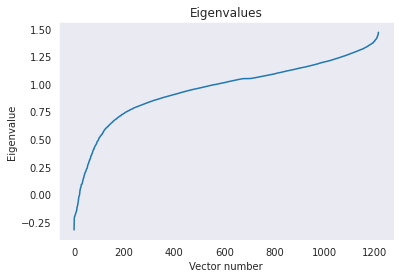

In [255]:
plt.plot(vals)
plt.xlabel('Vector number')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues')

In [256]:
vecs = vecs[:,np.argsort(vals)[::-1]]
vals = vals[np.argsort(vals)[::-1]]
vals[:10]

array([1.46879857, 1.44873971, 1.4430308 , 1.43788984, 1.43345769,
       1.41982134, 1.41817376, 1.41685117, 1.41105104, 1.40753898])

# **Corresponding Cities**

In [257]:
def plot_eigenvector_cities(start):
  fig,axs = plt.subplots(2,4,figsize = (17,10),constrained_layout=True)
  plt.suptitle("Cities corresponding to Leading eigenvectors:",fontsize=20)
  for i,ax in enumerate(axs.flatten()):
      V = vecs[i+1+start]
      percentile = np.percentile(V,99.5)
      big, small = np.where(V>percentile), np.where(V<percentile)
      ax.scatter(c_mtx[convert_idx,0][small],c_mtx[convert_idx,1][small],c = V[small],cmap="Blues",s=15,alpha=0.1,label='weak')
      ax.scatter(c_mtx[convert_idx,0][big],c_mtx[convert_idx,1][big],c = 'orange',marker='s',s=35,alpha=1,label='strong')
      for idx in big[0]:
        ax.annotate(names.iloc[idx][::-1], (c_mtx[convert_idx,0][idx],c_mtx[convert_idx,1][idx]))
      ax.tick_params(axis='both', which='both',          
                    bottom=False,labelbottom=False,
                    left=False,labelleft=False) 
      ax.set_xlim([10**4,3*10**4])
      ax.set_ylim([3*10**4,8.5*10**4])
      ax.set_title("Eigenvector " + str(i+1+start))
      ax.legend()

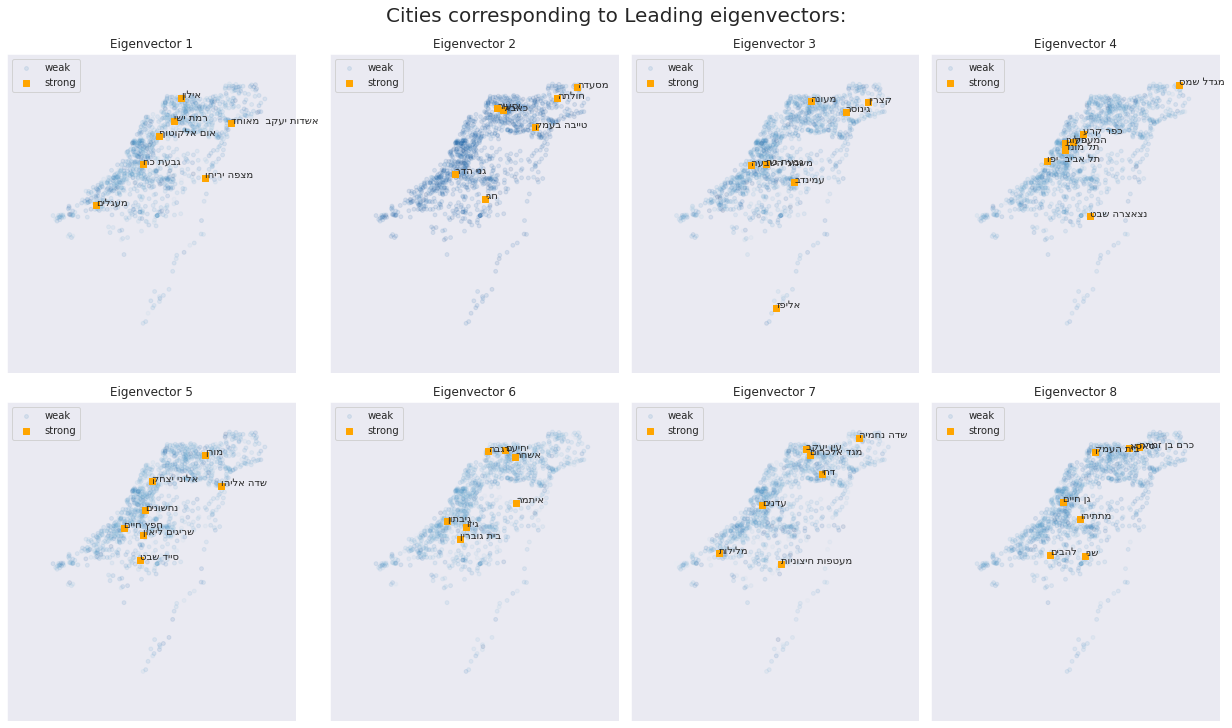

In [258]:
plot_eigenvector_cities(0)

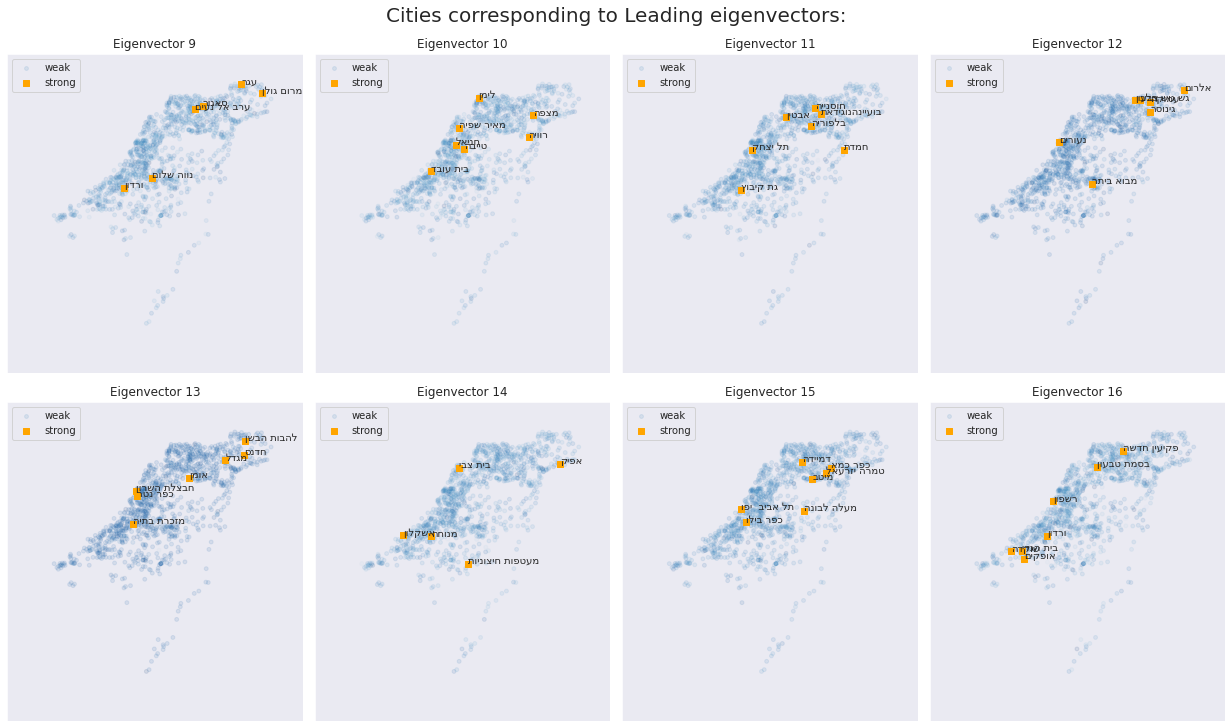

In [259]:
plot_eigenvector_cities(8)

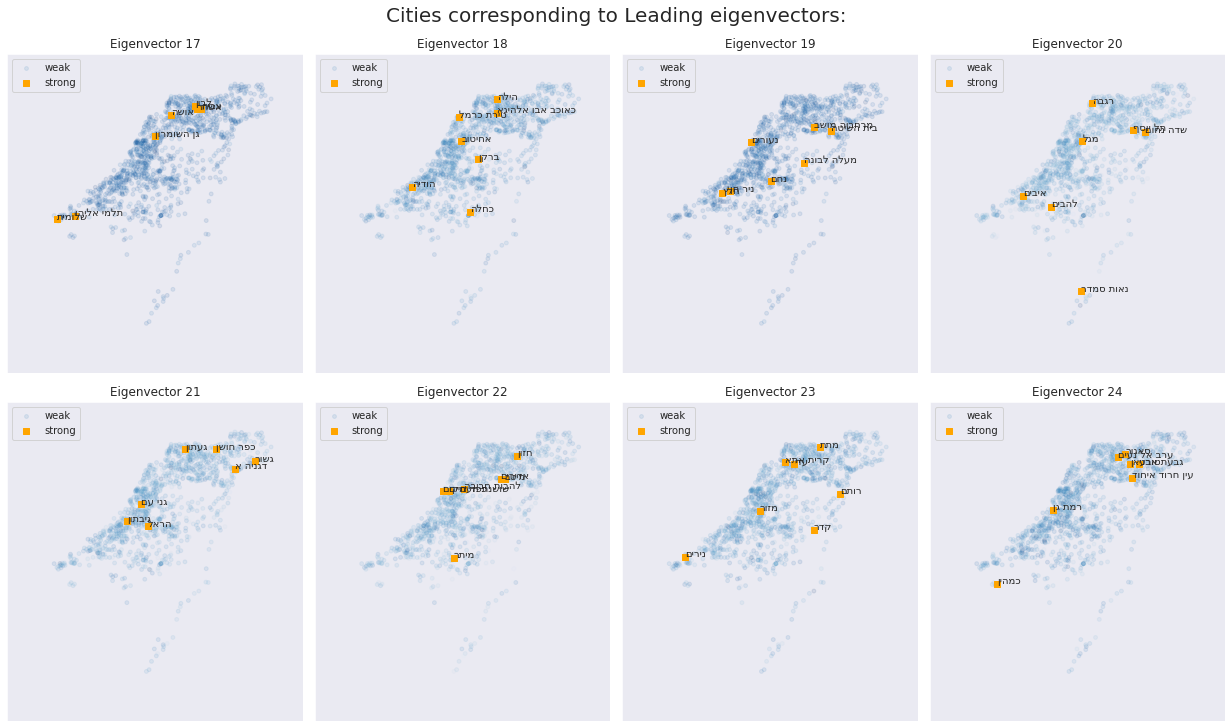

In [260]:
plot_eigenvector_cities(16)

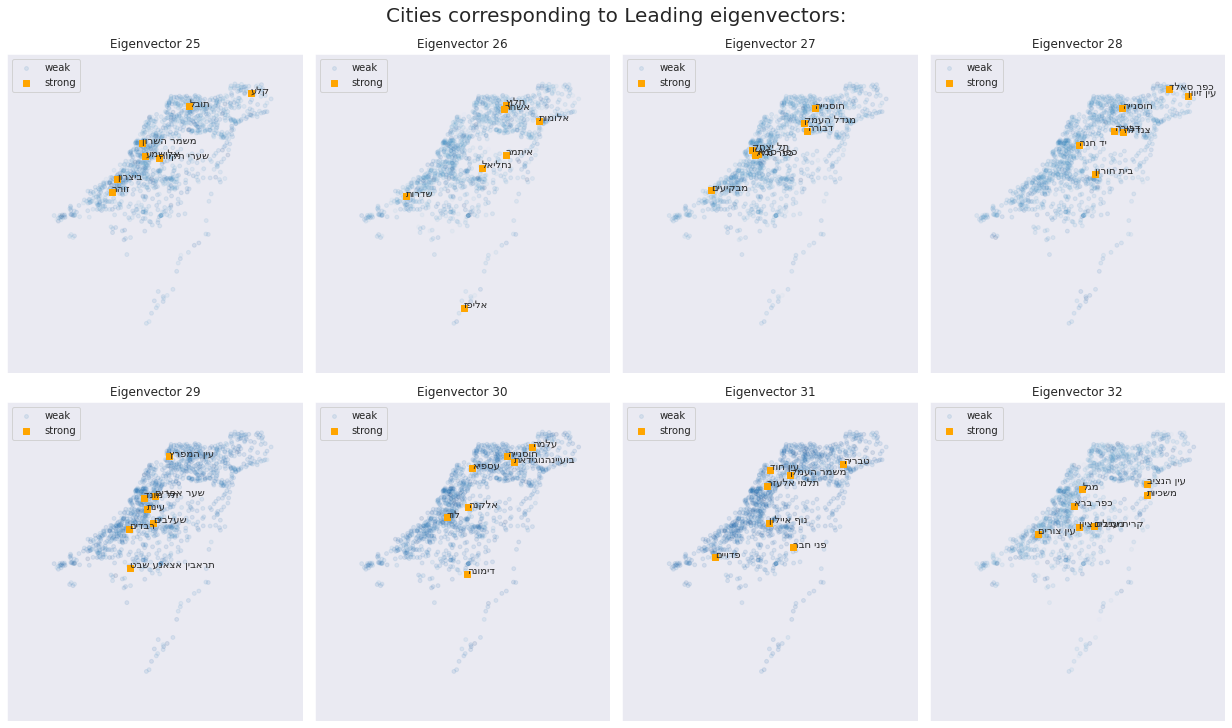

In [261]:
plot_eigenvector_cities(24)

# **Spectral Clustring**

In [262]:
import warnings
warnings.filterwarnings("ignore")

In [263]:
def plot_spectral_clustering(df):
    fig_1, axs = plt.subplots(3,4,figsize = (13,10),constrained_layout=True)
    plt.suptitle('Spectral Clustering',fontsize=20)
    for i,ax in enumerate(axs.flatten()):
      clustering_1 = SpectralClustering(n_clusters=(4*i+2)).fit_predict(df)
      ax.scatter(c_mtx[convert_idx,0],c_mtx[convert_idx,1], c=clustering_1,cmap="Spectral",s=12)
      ax.tick_params(axis='both', which='both',          
                     bottom=False,labelbottom=False,
                     left=False,labelleft=False) 
      ax.set_title(str(4*i+2) + " Components")
      ax.set_xlim([10**4,3*10**4])
      ax.set_ylim([3*10**4,8.5*10**4])

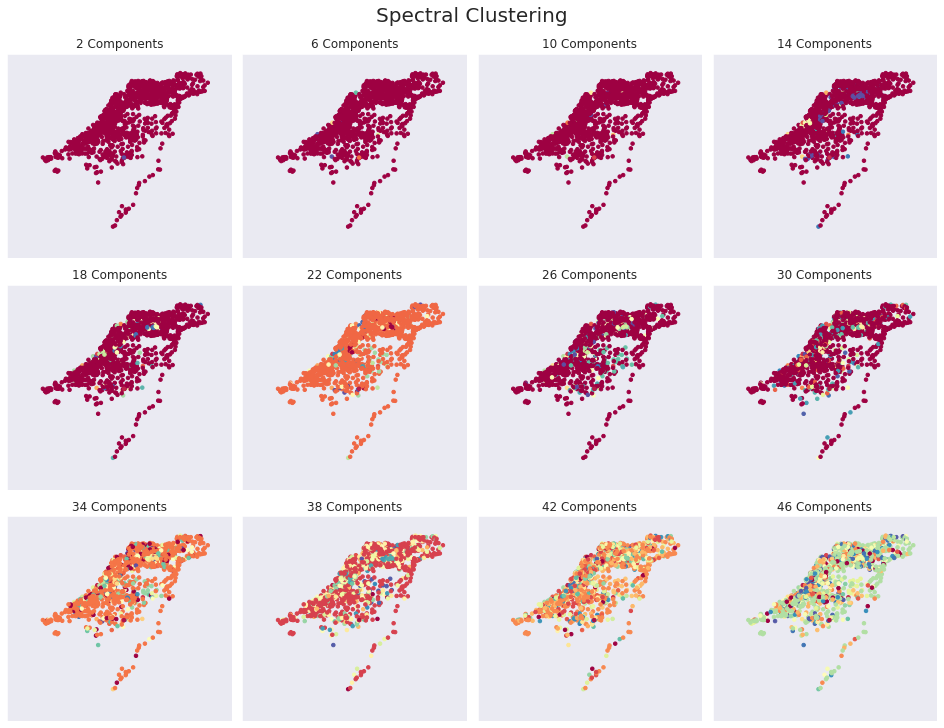

In [264]:
plot_spectral_clustering(X)

# **Correlation Between Election data and Eigenvectors**

In [265]:
X = scaler.fit_transform(data)
correlation_df = pd.DataFrame(index=data.columns,columns=range(1,32))
for idx, row in enumerate(data.columns):
  for eigenvec in correlation_df.columns:
    correlation_df.loc[row][eigenvec] = round(np.corrcoef(vecs[eigenvec-1],X[:, idx])[1][0],5)
correlation_df.drop('rk',inplace=True)
correlation_df.astype(float).style.background_gradient(cmap='coolwarm')

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31
BZB,0.009720,-0.037090,-0.013690,0.018390,0.043250,-0.044500,-0.013430,0.009100,-0.011310,0.056550,-0.005630,0.031970,0.027670,0.046150,-0.008160,0.011980,-0.022850,-0.000670,0.018540,-0.009050,0.013200,-0.009920,-0.008050,0.023150,0.013030,-0.036070,-0.016140,0.033910,-0.035060,0.049060,-0.026020
Voters,0.007740,-0.021870,-0.009180,0.017940,0.034130,-0.019710,0.000290,0.119070,-0.009460,0.046040,0.002790,0.024980,0.018370,0.035740,0.181450,0.010740,-0.014560,0.005530,0.012850,-0.006890,0.061740,-0.003190,0.002070,0.019570,0.012670,-0.026860,-0.006760,0.029330,-0.031550,0.041810,-0.023560
Disqualified,0.014100,-0.030870,-0.010620,0.016660,0.016080,-0.008660,0.006860,0.152250,-0.013210,0.036830,0.004640,0.008390,0.019060,0.018940,0.251690,-0.006460,-0.013660,0.017750,0.009350,0.001540,0.078430,0.005070,0.002490,0.015030,0.014750,-0.017970,-0.007050,0.026630,-0.016660,0.024860,-0.011160
Eligible,0.007690,-0.021800,-0.009170,0.017940,0.034240,-0.019780,0.000250,0.118780,-0.009420,0.046080,0.002770,0.025080,0.018350,0.035840,0.180860,0.010860,-0.014560,0.005440,0.012860,-0.006940,0.061590,-0.003250,0.002070,0.019590,0.012650,-0.026910,-0.006760,0.029340,-0.031640,0.041910,-0.023630
Labor,0.003330,0.014800,-0.000310,0.021910,0.064990,0.001070,0.005210,0.115420,0.006870,0.026450,-0.007790,0.042630,0.006700,0.052990,0.164120,0.053700,-0.005810,-0.008360,0.008740,-0.012250,0.056870,-0.008960,0.003270,0.000030,0.003100,-0.023000,0.010380,-0.007760,-0.020560,0.038610,-0.008110
Yamina,0.006310,-0.014220,-0.001870,0.012500,0.009610,-0.015630,0.007220,0.140150,-0.014370,0.032160,0.011550,0.017620,0.010840,0.020080,0.228750,-0.005120,-0.012550,0.002960,0.006870,-0.004400,0.063700,-0.004980,0.009880,0.024010,0.011000,-0.022880,0.000030,0.036080,-0.033400,0.028980,-0.037450
Yahadut,0.004140,-0.075600,-0.021030,0.017710,0.019140,-0.027090,-0.009650,0.044110,-0.032460,0.047550,0.009370,0.017570,0.034840,0.011230,0.078500,-0.027450,-0.027530,-0.003970,-0.006040,-0.003860,0.035510,0.031570,0.018930,0.035440,0.018450,0.007680,-0.025070,0.051600,-0.037790,0.019600,-0.033760
Daam,0.029860,-0.072300,-0.019650,-0.013480,0.030340,-0.024410,0.002230,0.083690,0.011360,0.011560,0.014870,0.034190,0.015160,0.019660,0.122180,0.003850,-0.010590,0.044670,0.000280,0.053060,0.040490,0.002260,-0.029100,0.013170,0.003640,-0.020920,-0.033600,-0.033430,0.001060,0.006540,0.018150
z,0.014410,-0.009610,0.001890,0.013420,0.023570,-0.002530,0.022550,0.151010,0.003860,0.020080,-0.001930,0.018530,0.019200,0.017900,0.252530,0.012120,-0.000370,0.016260,0.011910,0.002210,0.087110,-0.002990,0.001210,0.012140,0.008300,-0.020250,-0.008250,0.015940,-0.008000,0.028850,0.000420
zt,0.015400,-0.023920,-0.010550,0.031580,-0.000200,-0.000210,0.003140,0.159900,-0.002710,0.016740,0.021160,-0.007040,0.015710,0.013760,0.227670,0.013680,0.012710,0.000890,0.034700,0.018150,0.067290,0.009760,0.007140,-0.004910,0.014550,0.005110,0.014060,0.011170,-0.038640,0.012370,0.019170
